### XGBoost（极端梯度提升）算法详解


#### 一、核心概念  
XGBoost（eXtreme Gradient Boosting）是GBDT的工程优化版本，通过**正则化提升**和**并行计算**显著提升了性能和效率。其核心思想是：在GBDT基础上引入更强的正则化机制，同时优化计算过程，实现更快的训练速度和更高的预测精度。  

- **关键特性**：  
  - **正则化**：通过L1/L2正则化控制模型复杂度，有效防止过拟合；  
  - **并行化**：在特征粒度上并行计算分裂增益（非树结构并行），大幅提升训练速度；  
  - **缺失值处理**：自动学习缺失值的分裂方向，无需手动填充；  
  - **自定义损失函数**：支持自定义一阶和二阶导数，灵活适应用于不同场景。  


#### 二、核心原理  
XGBoost继承了GBDT的**加法模型**和**梯度提升**思想，但在细节上做了重要优化：  

1. **目标函数优化**：  
   目标函数 = 损失函数 + 正则化项  
   其中，正则化项包含树的叶子节点数量和叶子节点值的平方和，控制树的复杂度。  

2. **分裂点查找**：  
   - 采用**直方图优化**：将连续特征值离散化为直方图，减少分裂点计算量；  
   - **近似算法**：对高维特征采用分位数近似，平衡精度和效率。  

3. **缺失值处理**：  
   训练时自动学习缺失值应被分配到左子树还是右子树，预测时直接应用学习到的规则。  

4. **收缩与采样**：  
   - 类似GBDT的学习率（shrinkage），控制每棵树的贡献；  
   - 支持样本和特征的随机采样（colsample_bytree/bylevel），增强泛化能力。  


#### 三、超参数影响  
- **`max_depth`**：树的最大深度（默认3）。过深易过拟合，通常取值3-10；  
- **`learning_rate`**：学习率（默认0.1）。与`n_estimators`协同，小学习率需更多树；  
- **`n_estimators`**：树的数量（默认100）。数量不足欠拟合，过多则过拟合；  
- **`subsample`**：样本采样比例（默认1.0）。小于1.0为随机采样，降低过拟合；  
- **`colsample_bytree`**：特征采样比例（默认1.0）。控制每棵树使用的特征比例；  
- **`reg_alpha`/`reg_lambda`**：L1/L2正则化系数（默认0）。值越大，正则化越强。  


#### 四、适用场景与优缺点  
- **适用场景**：  
  - 结构化数据建模（如金融风控、用户画像）；  
  - 分类任务（二分类/多分类）、回归任务、排序任务；  
  - 数据竞赛（Kaggle等平台的常用冠军模型）。  

- **优点**：  
  1. 预测精度高，在多数结构化数据任务上优于GBDT；  
  2. 训练速度快（直方图优化+并行计算）；  
  3. 内置正则化机制，抗过拟合能力强；  
  4. 支持缺失值自动处理和自定义损失函数。  

- **缺点**：  
  1. 超参数调优复杂（参数多且相互影响）；  
  2. 对超高维稀疏数据（如文本）不如深度学习；  
  3. 相比线性模型，解释性较弱（但优于深度学习）。  


#### 五、代码实例（3个独立Python文件）  


##### 1. 简洁版：XGBoost基础使用（分类与回归） 

=== 分类任务评估 ===
准确率：0.9532

分类报告：
              precision    recall  f1-score   support

           0       0.95      0.92      0.94        64
           1       0.95      0.97      0.96       107

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



<Figure size 1000x600 with 0 Axes>

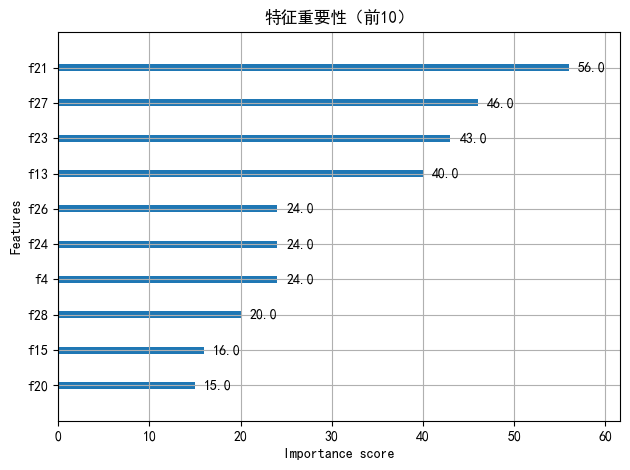

In [22]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import xgboost as xgb

# 1. XGBoost分类（乳腺癌数据集）
def xgboost_classification():
    # 加载数据
    data = load_breast_cancer()
    X, y = data.data, data.target

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # 定义XGBoost分类器
    clf = xgb.XGBClassifier(
        objective='binary:logistic',  # 二分类目标函数
        n_estimators=100,             # 树的数量
        max_depth=3,                  # 树的最大深度
        learning_rate=0.1,            # 学习率
        random_state=42,
        eval_metric='logloss'         # 评估指标
    )
    
    # 训练模型
    clf.fit(X_train, y_train)
    
    # 预测与评估
    y_pred = clf.predict(X_test)
    print("=== 分类任务评估 ===")
    print(f"准确率：{accuracy_score(y_test, y_pred):.4f}")
    print("\n分类报告：")
    print(classification_report(y_test, y_pred))
    
    # 特征重要性可视化
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(clf, max_num_features=10, title="特征重要性（前10）")
    plt.tight_layout()
    plt.show()

xgboost_classification()


=== 回归任务评估 ===
均方误差（MSE）：0.2856
决定系数（R²）：0.7824


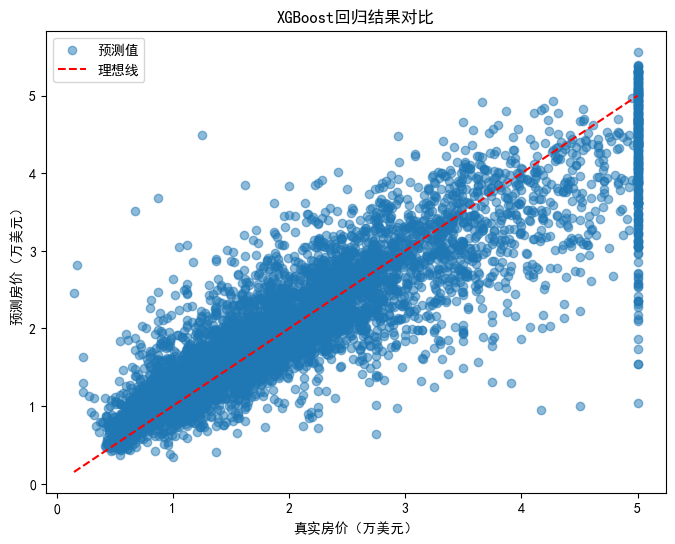

In [23]:
# 2. XGBoost回归（房价数据集）
def xgboost_regression():
    # 加载数据
    data = fetch_california_housing()
    X, y = data.data, data.target
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # 定义XGBoost回归器
    reg = xgb.XGBRegressor(
        objective='reg:squarederror',  # 回归目标函数（平方误差）
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )
    
    # 训练模型
    reg.fit(X_train, y_train)
    
    # 预测与评估
    y_pred = reg.predict(X_test)
    print("\n=== 回归任务评估 ===")
    print(f"均方误差（MSE）：{mean_squared_error(y_test, y_pred):.4f}")
    print(f"决定系数（R²）：{r2_score(y_test, y_pred):.4f}")
    
    # 真实值 vs 预测值可视化
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label='预测值')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='理想线')
    plt.xlabel('真实房价（万美元）')
    plt.ylabel('预测房价（万美元）')
    plt.title('XGBoost回归结果对比')
    plt.legend()
    plt.show()

xgboost_regression()

##### 2. 进阶版：XGBoost交叉验证与早停  

[0]	train-auc:0.98780+0.00417	test-auc:0.95501+0.01592
[50]	train-auc:1.00000+0.00000	test-auc:0.98543+0.01383
[54]	train-auc:1.00000+0.00000	test-auc:0.98543+0.01389
最佳迭代轮次：36
最佳交叉验证AUC：0.9861
[0]	train-auc:0.98570	eval-auc:0.94918
[50]	train-auc:0.99995	eval-auc:0.99314
[91]	train-auc:1.00000	eval-auc:0.99387

测试集评估：
准确率：0.9532
AUC：0.9939


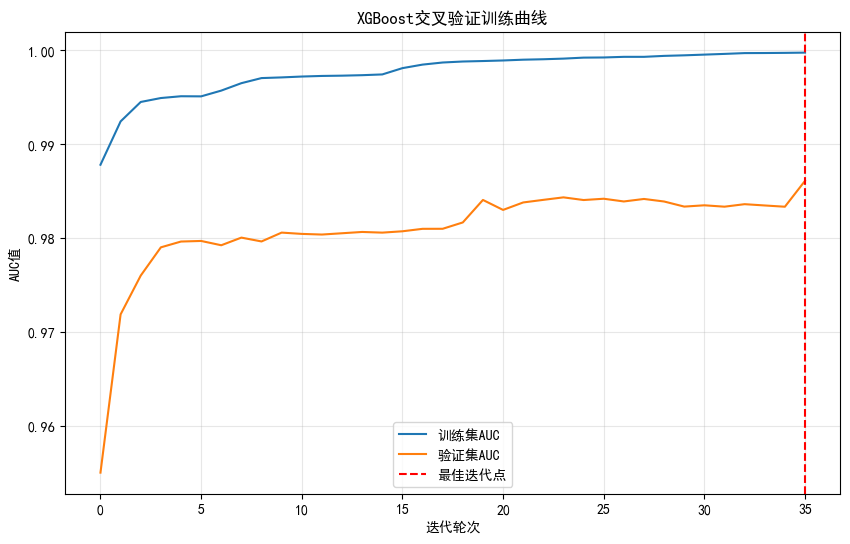

In [11]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_auc_score

def xgboost_cv_early_stopping():
    # 加载数据
    data = load_breast_cancer()
    X, y = data.data, data.target
    
    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # 转换为XGBoost专用DMatrix格式（高效处理）
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # 设置模型参数
    params = {
        'objective': 'binary:logistic',  # 二分类
        'max_depth': 3,
        'learning_rate': 0.1,
        'eval_metric': 'auc',            # 用AUC评估
        'random_state': 42
    }
    
    # 1. 交叉验证（5折）
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,            # 最大迭代次数
        nfold=5,                         # 5折交叉验证
        stratified=True,                 # 分类任务使用分层抽样
        early_stopping_rounds=20,        # 早停：20轮无提升则停止
        verbose_eval=50,                 # 每50轮打印一次结果
        seed=42
    )
    
    print(f"最佳迭代轮次：{cv_results.shape[0]}")
    print(f"最佳交叉验证AUC：{cv_results['test-auc-mean'].iloc[-1]:.4f}")
    
    # 2. 使用早停策略训练最终模型
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]  # 监控训练集和验证集
    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=watchlist,
        early_stopping_rounds=20,  # 验证集性能下降则停止
        verbose_eval=50
    )
    
    # 3. 评估模型
    y_pred_prob = model.predict(dtest)
    y_pred = (y_pred_prob > 0.5).astype(int)  # 概率转标签
    
    print("\n测试集评估：")
    print(f"准确率：{accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC：{roc_auc_score(y_test, y_pred_prob):.4f}")
    
    # 4. 可视化训练曲线
    plt.figure(figsize=(10, 6))
    plt.plot(cv_results['train-auc-mean'], label='训练集AUC')
    plt.plot(cv_results['test-auc-mean'], label='验证集AUC')
    plt.axvline(x=cv_results.shape[0]-1, color='r', linestyle='--', label='最佳迭代点')
    plt.xlabel('迭代轮次')
    plt.ylabel('AUC值')
    plt.title('XGBoost交叉验证训练曲线')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

xgboost_cv_early_stopping()

##### 3. 调优版：XGBoost超参数网格搜索  

Fitting 3 folds for each of 64 candidates, totalling 192 fits
最佳参数组合：
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 5
  min_child_weight: 1
  n_estimators: 200
  subsample: 1.0

测试集MSE：0.2112
测试集R²：0.8391


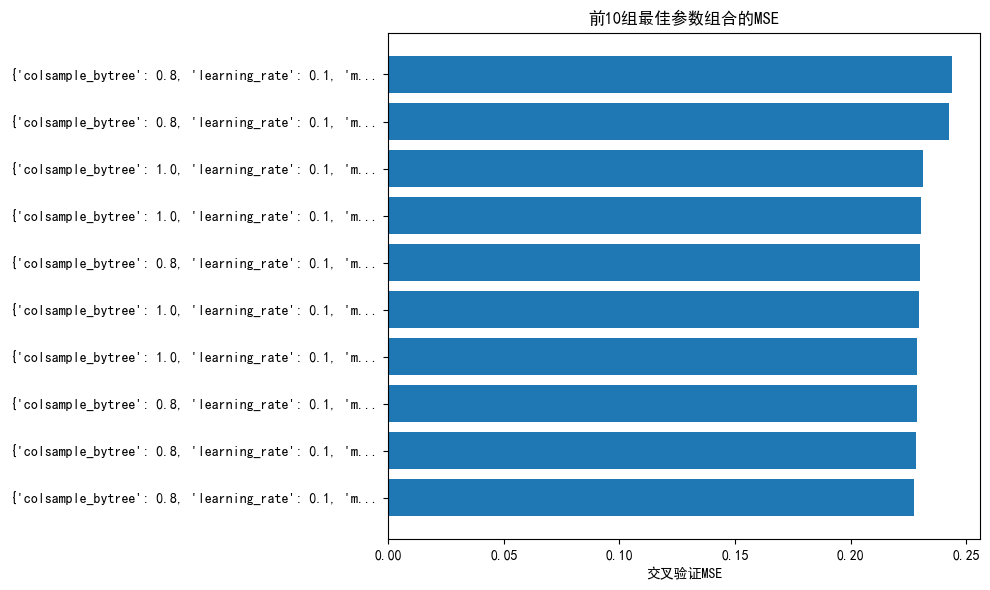

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

def xgboost_hyperparameter_tuning():
    # 加载回归数据集
    data = fetch_california_housing()
    X, y = data.data, data.target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # 定义基础模型
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    )
    
    # 定义参数网格（分阶段调优，先树结构，后正则化）
    param_grid = {
        # 树结构参数
        'max_depth': [3, 5],
        'min_child_weight': [1, 3],
        # 学习过程参数
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        # 采样参数
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    # 网格搜索（3折交叉验证）
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',  # 用负MSE作为评分
        n_jobs=-1,                          # 并行计算
        verbose=1
    )
    
    # 执行搜索
    grid_search.fit(X_train, y_train)
    
    # 输出最佳参数
    print("最佳参数组合：")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    
    # 最佳模型评估
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f"\n测试集MSE：{mean_squared_error(y_test, y_pred):.4f}")
    print(f"测试集R²：{r2_score(y_test, y_pred):.4f}")
    
    # 可视化参数重要性（提取前10组结果）
    results = pd.DataFrame(grid_search.cv_results_)
    results = results[['params', 'mean_test_score']]
    results['mean_test_score'] = -results['mean_test_score']  # 转换为MSE
    results = results.sort_values('mean_test_score').head(10)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(results)), results['mean_test_score'])
    plt.yticks(range(len(results)), [str(p)[:50] + '...' for p in results['params']])
    plt.xlabel('交叉验证MSE')
    plt.title('前10组最佳参数组合的MSE')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    xgboost_hyperparameter_tuning()


##### 4. 对比版：XGBoost与其他模型性能比较  

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import xgboost as xgb
from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    mean_squared_error, r2_score
)

# 可视化对比结果
def plot_comparison(results_df, title):
    metrics = results_df.columns[1:]
    n_metrics = len(metrics)
    
    plt.figure(figsize=(5*n_metrics, 6))
    for i, metric in enumerate(metrics):
        plt.subplot(1, n_metrics, i+1)
        plt.bar(results_df["模型"], results_df[metric])
        plt.title(f"{metric}对比")
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

=== 分类任务性能对比 ===
        模型     准确率     AUC  训练时间(s)
0  XGBoost  0.9532  0.9939   0.0360
1     GBDT  0.9474  0.9899   0.3286
2     随机森林  0.9357  0.9883   0.1275


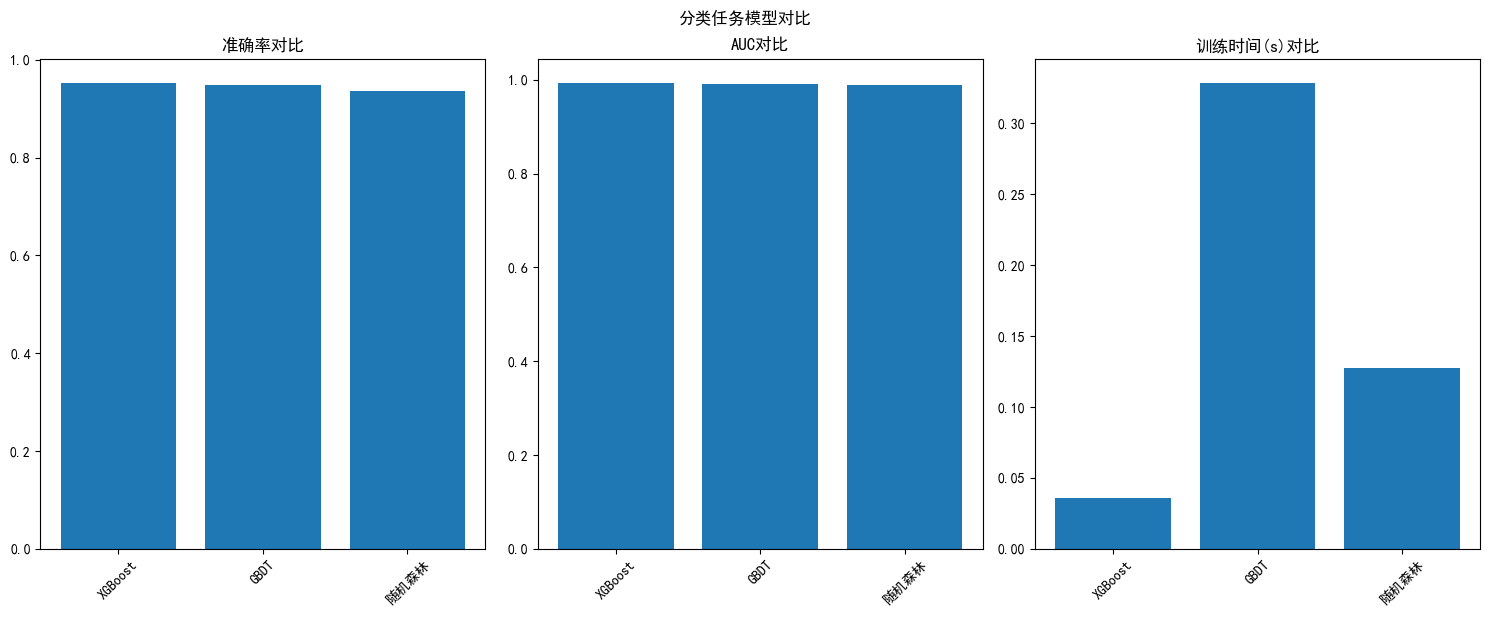

In [20]:
# 1. 分类任务对比（乳腺癌数据集）
def classification_comparison():
    data = load_breast_cancer()
    X, y = data.data, data.target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # 定义模型列表（移除XGBoost中的use_label_encoder参数）
    models = {
        "XGBoost": xgb.XGBClassifier(
            objective='binary:logistic',
            n_estimators=100, max_depth=3,
            learning_rate=0.1, random_state=42,
            eval_metric='logloss'  # 仅保留必要参数
        ),
        "GBDT": GradientBoostingClassifier(
            n_estimators=100, max_depth=3,
            learning_rate=0.1, random_state=42
        ),
        "随机森林": RandomForestClassifier(
            n_estimators=100, max_depth=3,
            random_state=42
        )
    }
    
    # 训练与评估
    results = []
    for name, model in models.items():
        # 计时
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # 预测
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        
        # 评估指标
        results.append({
            "模型": name,
            "准确率": accuracy_score(y_test, y_pred),
            "AUC": roc_auc_score(y_test, y_pred_prob),
            "训练时间(s)": round(train_time, 4)
        })
    
    # 展示结果
    results_df = pd.DataFrame(results)
    print("=== 分类任务性能对比 ===")
    print(results_df.round(4))
    
    # 可视化
    plot_comparison(results_df, "分类任务模型对比")

classification_comparison()


=== 回归任务性能对比 ===
        模型     MSE      R²  训练时间(s)
0  XGBoost  0.2856  0.7824   0.0464
1     GBDT  0.2884  0.7803   2.7648
2     随机森林  0.5938  0.5476   1.7859


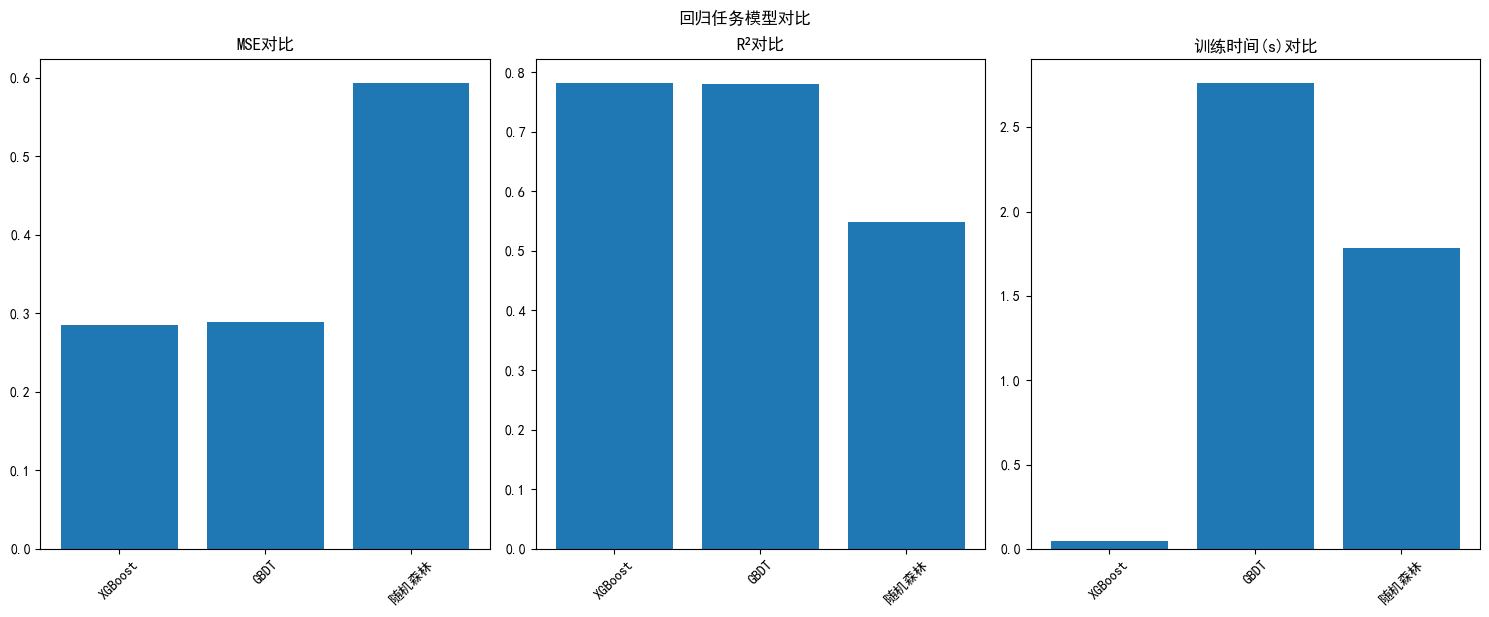

In [21]:
# 2. 回归任务对比（房价数据集）
def regression_comparison():
    data = fetch_california_housing()
    X, y = data.data, data.target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # 定义模型列表
    models = {
        "XGBoost": xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100, max_depth=3,
            learning_rate=0.1, random_state=42
        ),
        "GBDT": GradientBoostingRegressor(
            n_estimators=100, max_depth=3,
            learning_rate=0.1, random_state=42
        ),
        "随机森林": RandomForestRegressor(
            n_estimators=100, max_depth=3,
            random_state=42
        )
    }
    
    # 训练与评估
    results = []
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = model.predict(X_test)
        results.append({
            "模型": name,
            "MSE": mean_squared_error(y_test, y_pred),
            "R²": r2_score(y_test, y_pred),
            "训练时间(s)": round(train_time, 4)
        })
    
    # 展示结果
    results_df = pd.DataFrame(results)
    print("\n=== 回归任务性能对比 ===")
    print(results_df.round(4))
    
    # 可视化
    plot_comparison(results_df, "回归任务模型对比")

regression_comparison() 

### 总结  
XGBoost作为工业界的“瑞士军刀”，在结构化数据任务中表现卓越。使用时需注意以下关键点：  

1. **数据格式**：优先使用XGBoost的`DMatrix`格式，支持缺失值自动处理和特征权重设置；  
2. **调参策略**：分阶段调优（先树结构参数→再采样参数→最后正则化参数），配合交叉验证和早停策略；  
3. **正则化平衡**：当训练精度远高于验证精度时，增大`reg_alpha`/`reg_lambda`或减小`max_depth`；  
4. **效率优化**：通过`subsample`和`colsample_bytree`减少采样比例，或使用`gpu_hist`树方法（需GPU支持）加速训练。  